In [20]:
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

from scipy import stats
from scipy.stats import norm,skew
import math 


In [2]:
data = load_boston() 

df_Boston = pd.DataFrame(data=data['data'], columns=data['feature_names'])
df_Boston['Price'] = data['target']

extract_df = df_Boston.loc[:, ['RM','Price']]
df_Boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


We know that RM and Price are highly correlated, now let's perform a simple train/test/split and linear regression and see how our model generalizes !

In [3]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
x = extract_df['RM'].values.reshape(-1,1)
y = extract_df['Price'].values.reshape(-1,1)
clf = LinearRegression()
#Train, test & split 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
error = mean_squared_error(y_test,y_pred)
print(error)
print(r2_score(y_test,y_pred))

39.0910511149
0.483459016892


Let's try and understand the distribution of Price and see if we can fix any skewness !

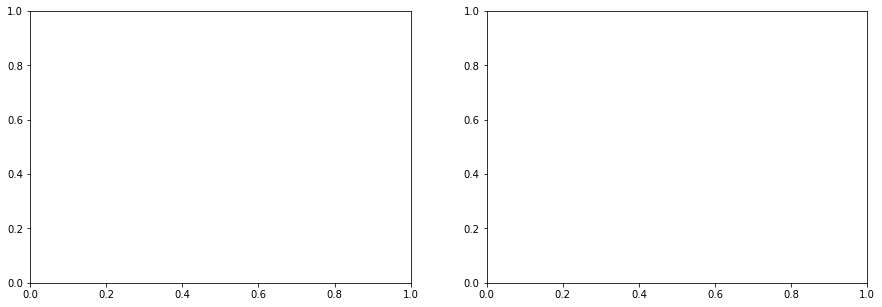

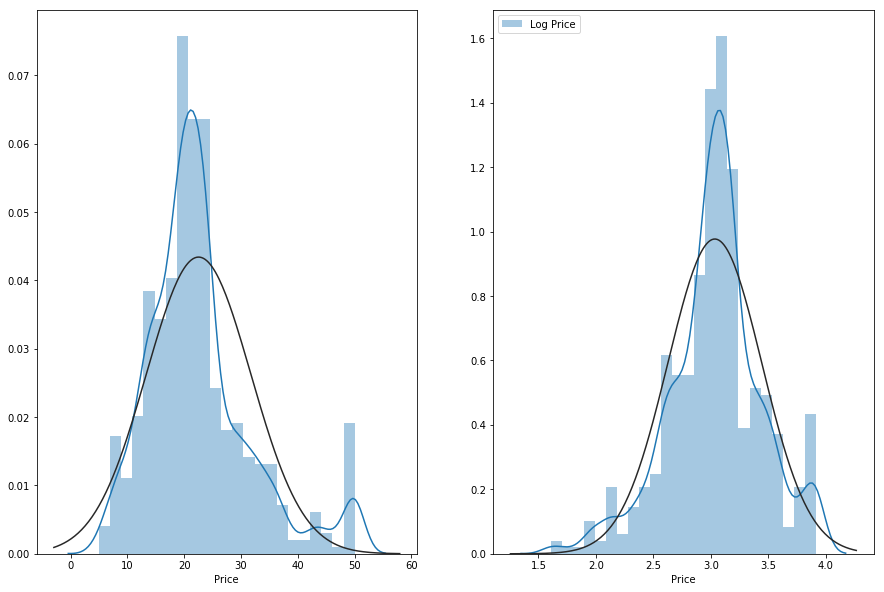

In [4]:
log_price = pd.Series(np.log(extract_df['Price']))
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
sns.distplot(log_price, ax=ax2,fit=norm,label='Log Price')
sns.distplot(extract_df['Price'],ax=ax1,fit=norm,label='Price')
plt.legend(loc='upper left')
plt.show()


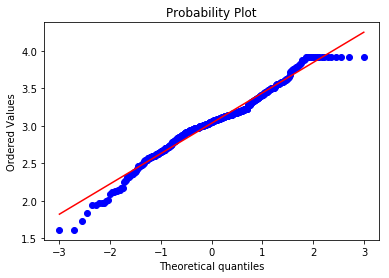

In [5]:
# Let's look at the probability plot of Log Price to ensure we've got a somewhat normal distribution. 
res = stats.probplot(log_price,plot=plt)
plt.show()

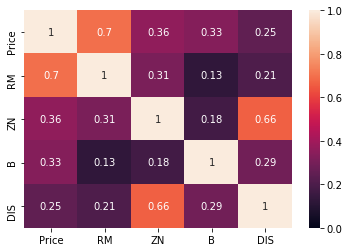

In [6]:
# Correlation Matrix - Let's get the top 5 correlations for Price
k = 5
corrmat = df_Boston.corr()
cols=corrmat.nlargest(k,'Price')['Price'].index
cm = np.corrcoef(df_Boston[cols].values.T)
sns.heatmap(cm,xticklabels=cols.values,yticklabels=cols.values,annot=True,vmin=0,vmax=1)
plt.show()

Now, let's take all RM, ZN,B and DIS as my features and perform a scatter matrix. It does look like DIS and ZN are highly correlated. Let's investigate this further. 

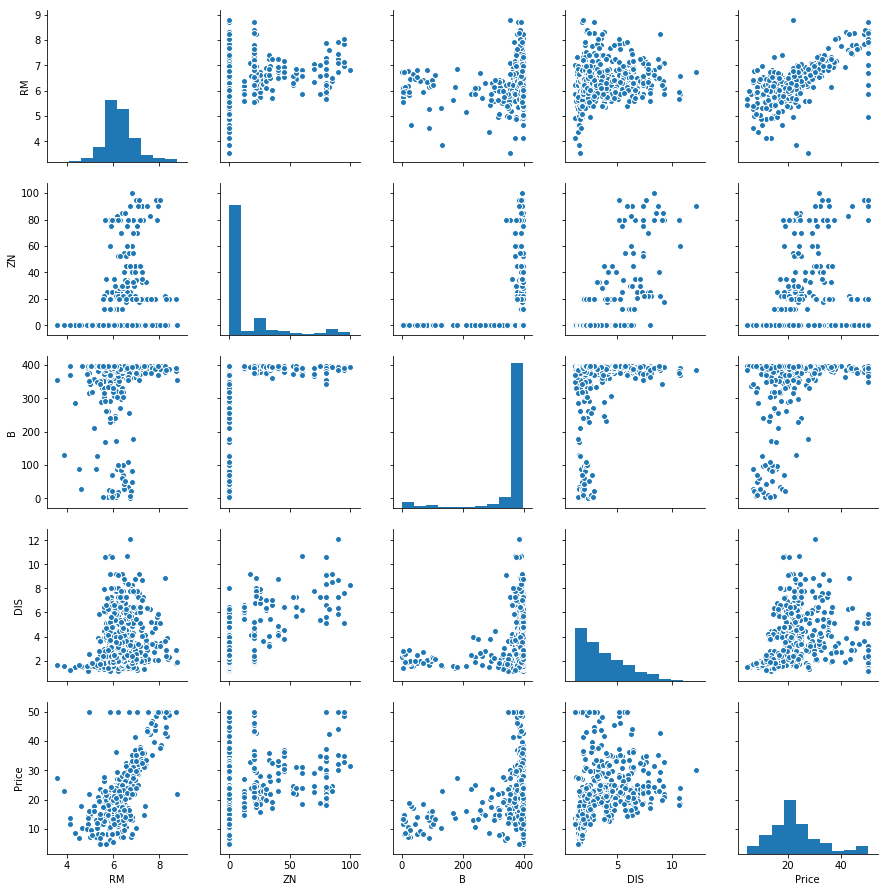

In [7]:
imp_features = df_Boston.loc[:, ['RM','ZN','B','DIS','Price']]
sns.pairplot(imp_features)
plt.show()

It's hard to tell whether it's a highly correlated variable or not. I'm going to study the eigenvalues and eigenvector of the correlation matrix to see if any of those values hover around 0. 


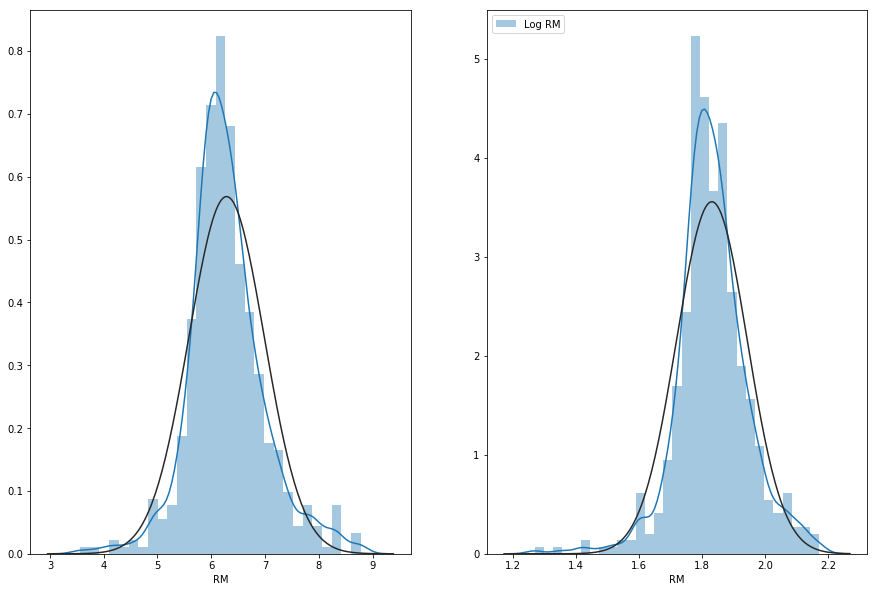

In [8]:
log_RM = pd.Series(np.log(extract_df['RM']))
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
sns.distplot(log_RM, ax=ax2,fit=norm,label='Log RM')
sns.distplot(extract_df['RM'],ax=ax1,fit=norm,label='RM')
plt.legend(loc='upper left')
plt.show()

In [9]:
x = imp_features.loc[:,['RM','ZN','DIS','B']]
y = imp_features['Price']

x_train2,x_test2,y_train2,y_test2 = train_test_split(x,y,test_size=0.33,random_state=42)
# Log Transformations
y_trainlog = np.log(y_train2)
y_testlog = np.log(y_test2)

Let's now perform linear regression with our new and improved set of x features

In [10]:
# Let's perform a train/test/split again
clf.fit(x_train2,y_trainlog)
pred = clf.predict(x_test2)
func = np.vectorize(lambda x:math.exp(x))
pred = func(pred)
error = mean_squared_error(y_test2,pred)
print(error)
print(r2_score(y_test2,pred))

27.4592323356
0.637159440294


In [11]:
# Now let's try standard scaler and then Linear regression
steps = [('scaler', StandardScaler()),('linear', LinearRegression())]
pipeline = Pipeline(steps)
pipeline.fit(x_train2,y_trainlog)
scaled_predict = pipeline.predict(x_test2)
scaled_predict = func(scaled_predict)
scaled_error = mean_squared_error(y_test2,scaled_predict)
print(scaled_error)
print(r2_score(y_test2,scaled_predict))

27.4592323356
0.637159440294


In [12]:
model = Ridge(alpha=0.5)
model.fit(x_train2,y_trainlog)
ridge_pred_unscale = model.predict(x_test2)
ridge_pred_unscale = func(ridge_pred_unscale)
ridge_error_unscale = mean_squared_error(y_test2,ridge_pred_unscale)
print(ridge_error_unscale)
print(r2_score(y_test2,ridge_pred_unscale))

27.5007709704
0.636610557451


In [13]:
# Nothing cha
steps =  [('scaler', StandardScaler()),('ridge', Ridge(alpha=1))]
pipeline = Pipeline(steps)
pipeline.fit(x_train2,y_trainlog)
ridge_pred_scale = pipeline.predict(x_test2)
ridge_pred_scale = func(ridge_pred_scale)
ridge_error_scale = mean_squared_error(y_test2,ridge_pred_scale)
print(ridge_error_scale)
print(r2_score(y_test2,ridge_pred_scale))

27.5027144785
0.636584876341


In [14]:
steps =  [('scaler', StandardScaler()),('ridge', Ridge(alpha=1))]
pipeline = Pipeline(steps)
pipeline.fit(x_train2,y_trainlog)
ridge_pred_scale = pipeline.predict(x_test2)
ridge_pred_scale = func(ridge_pred_scale)
ridge_error_scale = mean_squared_error(y_test2,ridge_pred_scale)
score = r2_score(y_test2,ridge_pred_scale)
print(ridge_error_scale)
print(score)

27.5027144785
0.636584876341


Regularization is affected by scaling. Let's perform Ridge regression on unscaled vs. scaled and see how the model performs. 

In [92]:
from sklearn.linear_model import Lasso
steps =  [('scaler', StandardScaler()),('Lasso', Lasso(alpha=1))]
pipeline = Pipeline(steps)
pipeline.fit(x_train2,y_trainlog)
lasso_pred = pipeline.predict(x_test2)
lasso_pred = func(lasso_pred)
lasso_error = mean_squared_error(y_test2,lasso_pred)


Let's try some ensemble learning

In [90]:
parameters = {'n_estimators':np.arange(100,1000,100)}
grid = GridSearchCV(regr,parameters,cv=5)
grid.fit(x_train2,y_trainlog)
print(grid.best_params_)

{'n_estimators': 700}


In [89]:
# Perform further regression models: RandomForestRegressor, SVMRegressor, 
from sklearn.ensemble import RandomForestRegressor 
regr = RandomForestRegressor(n_estimators=700)
regr.fit(x_train2, y_trainlog)
RF_predict = regr.predict(x_test2)
RF_predict = func(RF_predict)
RF_error = mean_squared_error(y_test2,RF_predict)
print(RF_error)
print(r2_score(y_test2,RF_predict))

20.8095932491
0.725026382038
